In [1]:
#Import Libraries
import numpy as np
import matplotlib.pylab as plt
import math
import pickle, gzip       
import sklearn
import gudhi as gd
import PersistenceImages.persistence_images as pimg

In [2]:
#These originally come from https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap
#They have been reduced from ~250,000 objects to 20,000 to comply with github upload restrictions and speed up computation

bitmaps = np.load('cello_cake_bitmaps_reduced.npy')

#We also have a vector of categories associated with each drawing.
#zeros are cellos, ones are cakes.
#They start out unscrambled with the first 10,000 being cellos and the second 10,000 being cakes

y = np.load('cello_cake_classes.npy')

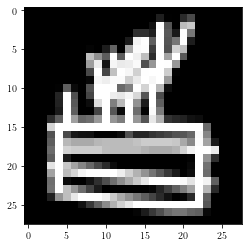

In [38]:
#The data comes as 1 by 784 arrays. 
#If we want to see what the images look like, we have to reshape them with this funtion.

#Subtracting the data from 255 makes it black on white instead of white on black.
#It doees give us different topological features, but all the same information should be there.

def view_bitmap(example):
    plt.imshow(example.reshape(28,28), cmap='gray');
    

view_bitmap(bitmaps[10010])

## Look at some Persistence Images

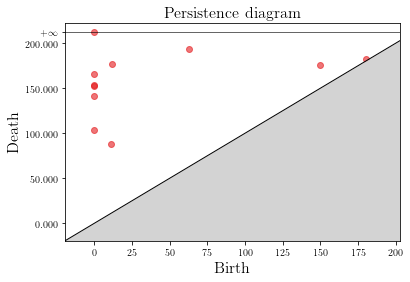

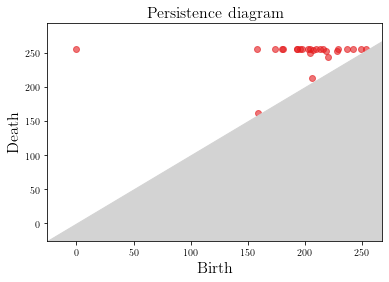

In [39]:
#Create a cubical complex object using the GUDHI package.
#Like the visualization function, we need to supply the dimensions of the image since this takes in a 1 by n vector.
#top_dimensional_cells is the image data itself
cubical = gd.CubicalComplex(dimensions = [28, 28], top_dimensional_cells =  bitmaps[10010])

#Calculate the persistent homology of the filtered cubical complex
phom = cubical.compute_persistence()
        
#Look at the 0-dimensional persistence homology 
phom_0 = cubical.persistence_intervals_in_dimension(0)
gd.plot_persistence_diagram(phom_0);

#Look at the 1-dimensional persitence homology
phom_1 = cubical.persistence_intervals_in_dimension(1)
gd.plot_persistence_diagram(phom_1);

In [10]:
#Initialize the persistance imager object
#This is also where we set the parameters of the Persistence Images.
#These have no canonical value, so we choose something that we thing works.
#There is a lot to experiment with here to give the best classification.

#In the case of cubical complex, birth_range and pers_range should match up with the range of values in the bitmap.
#Pixel size should divide the birth range and pixel range.

#Sigma should make the distribution wide enough so that similar cubical complexes can make similar images.

#It's also possible to change the weight function and its parameters. 

pers_imager = pimg.PersistenceImager()
pers_imager.pixel_size = 16
pers_imager.birth_range = (0,256)
pers_imager.pers_range = (0,256)
pers_imager.kernel_params['sigma'][0] = [200, 0]
pers_imager.kernel_params['sigma'][1] = [0, 200]

print(pers_imager.kernel_params['sigma'][0])
print(pers_imager)

[200.   0.]
PersistenceImager object: 
  pixel size: 16 
  resolution: (16, 16) 
  birth range: (0, 256) 
  persistence range: (0, 256) 
  weight: linear_ramp 
  kernel: bvncdf 
  weight parameters: {} 
  kernel parameters: {sigma: [[200.   0.]
 [  0. 200.]]}


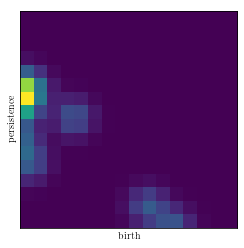

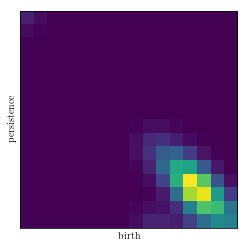

In [40]:
#Use the persistence imager object to obtain persistence images from our diagrams above

pers_imager.plot_image(phom_0, skew = True)
pers_imager.plot_image(phom_1, skew = True)

## Convert all bitmaps to persistence images

In [13]:
#This is a function that combines all the steps from the past few cells to convert an image to a persistence image.
#We use the same parameters from the persistence imager above.

def BitmapToImageVector(bitmap, imager):
    cubical = gd.CubicalComplex(dimensions = [28, 28], top_dimensional_cells = bitmap)
    phom = cubical.compute_persistence()
    phom_0 = cubical.persistence_intervals_in_dimension(0)
    phom_1 = cubical.persistence_intervals_in_dimension(1)
    
    pers_img_0 = imager.transform(phom_0, skew=True)
    pers_img_1 = imager.transform(phom_1, skew=True)
    
    pers_img_0 = np.resize(pers_img_0, (1, len(pers_img_0)**2))
    pers_img_1 = np.resize(pers_img_1, (1, len(pers_img_1)**2))

    ImageVector = np.concatenate((pers_img_0[0], pers_img_1[0]), axis=0)
    
    return(ImageVector)
    
PersImages = np.zeros((len(bitmaps), 512))

for i in range(len(bitmaps)):
    PersImages[i] = BitmapToImageVector(bitmaps[i], pers_imager)

## Machine Learning on raw bitmaps

In [14]:
from sklearn.model_selection import train_test_split
X_bmp_train, X_bmp_test, y_bmp_train, y_bmp_test = train_test_split(
    bitmaps, y, test_size=0.15, shuffle=True)

In [15]:
from sklearn.linear_model import LogisticRegression
clf_bitmaps = LogisticRegression(random_state=0, max_iter = 2000)
clf_bitmaps.fit(X_bmp_train, y_bmp_train)

print(clf_bitmaps.score(X_bmp_train, y_bmp_train))
print(clf_bitmaps.score(X_bmp_test, y_bmp_test))

C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9344705882352942
0.927


In [17]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

clf_xgboost = XGBClassifier()
clf_xgboost.fit(X_bmp_train, y_bmp_train)

# make predictions for test data
y_pred_test = clf_xgboost.predict(X_bmp_test)
predictions_test = [round(value) for value in y_pred_test]

y_pred_train = clf_xgboost.predict(X_bmp_train)
predictions_train = [round(value) for value in y_pred_train]

accuracy_train = accuracy_score(y_bmp_train, predictions_train)
print("Train Accuracy: %.2f%%" % (accuracy_train * 100.0))

accuracy_test = accuracy_score(y_bmp_test, predictions_test)
print("Test Accuracy: %.2f%%" % (accuracy_test * 100.0))

Train Accuracy: 100.00%
Test Accuracy: 96.17%


## Machine Learning on Persistence Images

In [18]:
X_pi_train, X_pi_test, y_pi_train, y_pi_test = train_test_split(
    PersImages, y, test_size=0.15, shuffle=True)

In [19]:
clf_logreg = LogisticRegression(penalty = 'l1')
clf_logreg.fit(X_pi_train, y_pi_train)

print(clf_logreg.score(X_pi_train, y_pi_train))
print(clf_logreg.score(X_pi_test, y_pi_test))

0.8049411764705883
0.7986666666666666


C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [42]:
clf_xgboost = XGBClassifier()
clf_xgboost.fit(X_pi_train, y_pi_train)

# make predictions for test data
y_pred_test = clf_xgboost.predict(X_pi_test)
predictions_test = [round(value) for value in y_pred_test]

y_pred_train = clf_xgboost.predict(X_pi_train)
predictions_train = [round(value) for value in y_pred_train]

accuracy_train = accuracy_score(y_pi_train, predictions_train)
print("Train Accuracy: %.2f%%" % (accuracy_train * 100.0))

accuracy_test = accuracy_score(y_pi_test, predictions_test)
print("Test Accuracy: %.2f%%" % (accuracy_test * 100.0))

Train Accuracy: 98.39%
Test Accuracy: 81.57%
